# Learning the Cumulative Sum with an RNN with the TensorFlow Scan Op.

In [1]:
from __future__ import division, print_function

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import matplotlib.pyplot as plt

import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import functional_ops

/Users/marvinbertin/anaconda/envs/TensorFlow-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def fn(previous_output, current_input):
    return previous_output + current_input

seq = tf.Variable([1.0, 2.0, 3.0, 5.0])
seq = tf.identity(seq)
init_acc = tf.constant(0.0)
seq_out = tf.scan(fn, seq, initializer=init_acc)

with tf.Session() as sess:
    init_var = tf.initialize_all_variables()
    sess.run(init_var)
    output = sess.run(seq_out)
    print(output)

[  1.   3.   6.  11.]


In [3]:
def input_target_generator(min_duration=5, max_duration=50):
    """ Generate toy input, target sequences.
    
    Each input sequence has values that are drawn from the standard normal
    distribution, and each target sequence is the corresponding cumulative sum.
    Sequence durations are chosen at random using a discrete uniform
    distribution over `[min_duration, max_duration]`.
    
    Args:
        min_duration: A positive integer. The minimum sequence duration.
        max_duration: A positive integer. The maximum sequence duration.

    Yields:
        A tuple,
        inputs: A 2-D float32 NumPy array with shape `[duration, 1]`.
        targets: A 2-D float32 NumPy array with shape `[duration, 1]`.
    """
    
    while True:
        duration = np.random.randint(min_duration, max_duration)
        inputs = np.random.randn(duration).astype(np.float32)
        targets = np.cumsum(inputs).astype(np.float32)
        yield inputs.reshape(-1, 1), targets.reshape(-1, 1)

In [4]:
in_seq, target_seq = input_target_generator(4, 10).next()
print("Input: \n", in_seq)
print("Target: \n", target_seq)

Input: 
 [[-0.35513273]
 [ 0.51373726]
 [-0.27540198]
 [ 0.68809217]
 [-0.87927586]
 [ 0.6664471 ]]
Target: 
 [[-0.35513273]
 [ 0.15860453]
 [-0.11679745]
 [ 0.57129472]
 [-0.30798113]
 [ 0.35846597]]


In [5]:
class Model(object):
    
    def __init__(self, hidden_layer_size, input_size, target_size, init_scale=0.1):
        """ Create a vanilla RNN.
        
        Args:
            hidden_layer_size: An integer. The number of hidden units.
            input_size: An integer. The number of inputs per time step.
            target_size: An integer. The number of targets per time step.
            init_scale: A float. All weight matrices will be initialized using
                a uniform distribution over [-init_scale, init_scale].
        """
        
        self.hidden_layer_size = hidden_layer_size
        self.input_size = input_size
        self.target_size = target_size
        self.init_scale = init_scale
        
        self._inputs = tf.placeholder(tf.float32, shape=[None, input_size],
                                      name='inputs')
        self._targets = tf.placeholder(tf.float32, shape=[None, target_size],
                                       name='targets')
        
        initializer = tf.random_uniform_initializer(-init_scale, init_scale)
        with tf.variable_scope('model', initializer=initializer):
            self._states, self._predictions = self._compute_predictions()
            self._loss = self._compute_loss()
    
#     def _vanilla_rnn_step(self, h_prev, x):
#         """ Vanilla RNN step.

#         Args:
#             h_prev: A 1-D float32 Tensor with shape `[hidden_layer_size]`.
#             x: A 1-D float32 Tensor with shape `[input_size]`.

#         Returns:
#             The updated state `h`, with the same shape as `h_prev`.
#         """
#         h_prev = tf.reshape(h_prev, [1, self.hidden_layer_size])
#         x = tf.reshape(x, [1, self.input_size])

#         with tf.variable_scope('rnn_block'):
#             W_h = tf.get_variable(
#                 'W_h', shape=[self.hidden_layer_size, self.hidden_layer_size])
#             W_x = tf.get_variable(
#                 'W_x', shape=[self.input_size, self.hidden_layer_size])
#             b = tf.get_variable('b', shape=[self.hidden_layer_size],
#                                 initializer=tf.constant_initializer(0.0))
#             h = tf.tanh( tf.matmul(h_prev, W_h) + tf.matmul(x, W_x) + b )
#             h = tf.reshape(h, [self.hidden_layer_size], name='h')
            
#         return h
    
    def GRU_step(self, h_prev, x):
        
        h_prev = tf.reshape(h_prev, [1, self.hidden_layer_size])
        x = tf.reshape(x, [1, self.input_size])

        with tf.variable_scope('rnn_block'):
            W_h = tf.get_variable(
                'W_h', shape=[self.hidden_layer_size, self.hidden_layer_size])
            W_x = tf.get_variable(
                'W_x', shape=[self.input_size, self.hidden_layer_size])
            b = tf.get_variable('b', shape=[self.hidden_layer_size],
                                initializer=tf.constant_initializer(0.0))
            
            U_r = tf.get_variable(
                'U_r', shape=[self.hidden_layer_size, self.hidden_layer_size])
            W_r = tf.get_variable(
                'W_r', shape=[self.input_size, self.hidden_layer_size])
            b_r = tf.get_variable('b_r', shape=[self.hidden_layer_size],
                                initializer=tf.constant_initializer(0.0))
            
            U_z = tf.get_variable(
                'U_z', shape=[self.hidden_layer_size, self.hidden_layer_size])
            W_z = tf.get_variable(
                'W_z', shape=[self.input_size, self.hidden_layer_size])
            b_z = tf.get_variable('b_z', shape=[self.hidden_layer_size],
                                initializer=tf.constant_initializer(0.0))
            
        
            r = tf.sigmoid(tf.matmul(x, W_r) + tf.matmul(h_prev, U_r) + b_r )
            z = tf.sigmoid(tf.matmul(x, W_z) + tf.matmul(h_prev, U_z) + b_z )

            h_prime = tf.tanh(tf.matmul(x, W_x) + tf.mul(r, tf.matmul(h_prev, W_h) + b ))
            h = tf.mul((1 - z), h_prev) + tf.mul(z, h_prime)
            h = tf.reshape(h, [self.hidden_layer_size], name='h')
            
        return h

#     def _compute_predictions(self):
#         """ Compute vanilla-RNN states and predictions. """

#         with tf.variable_scope('states'):
#             initial_state = tf.zeros([self.hidden_layer_size],
#                                      name='initial_state')
#             states = tf.scan(self._vanilla_rnn_step, self.inputs,
#                                          initializer=initial_state, name='states')

#         with tf.variable_scope('predictions'):
#             W_pred = tf.get_variable(
#                 'W_pred', shape=[self.hidden_layer_size, self.target_size])
#             b_pred = tf.get_variable('b_pred', shape=[self.target_size],
#                                      initializer=tf.constant_initializer(0.0))
#             predictions = tf.add(tf.matmul(states, W_pred), b_pred, name='predictions')
            
#         return states, predictions

    def _compute_predictions(self):
        """ Compute GRU-RNN states and predictions. """

        with tf.variable_scope('states'):
            initial_state = tf.zeros([self.hidden_layer_size],
                                     name='initial_state')
            states = tf.scan(self.GRU_step, self.inputs,
                                         initializer=initial_state, name='states')

        with tf.variable_scope('predictions'):
            W_pred = tf.get_variable(
                'W_pred', shape=[self.hidden_layer_size, self.target_size])
            b_pred = tf.get_variable('b_pred', shape=[self.target_size],
                                     initializer=tf.constant_initializer(0.0))
            predictions = tf.add(tf.matmul(states, W_pred), b_pred, name='predictions')
            
        return states, predictions

    def _compute_loss(self):
        """ Compute l2 loss between targets and predictions. """

        with tf.variable_scope('loss'):
            loss = tf.reduce_mean((self.targets - self.predictions)**2, name='loss')
            return loss
    
    @property
    def inputs(self):
        """ A 2-D float32 placeholder with shape `[dynamic_duration, input_size]`. """
        return self._inputs
    
    @property
    def targets(self):
        """ A 2-D float32 placeholder with shape `[dynamic_duration, target_size]`. """
        return self._targets
    
    @property
    def states(self):
        """ A 2-D float32 Tensor with shape `[dynamic_duration, hidden_layer_size]`. """
        return self._states
    
    @property
    def predictions(self):
        """ A 2-D float32 Tensor with shape `[dynamic_duration, target_size]`. """
        return self._predictions
    
    @property
    def loss(self):
        """ A 0-D float32 Tensor. """
        return self._loss

In [6]:
class Optimizer(object):
    
    def __init__(self, loss, initial_learning_rate, num_steps_per_decay,
                 decay_rate, max_global_norm=1.0):
        """ Create a simple optimizer.
        
        This optimizer clips gradients and uses vanilla stochastic gradient
        descent with a learning rate that decays exponentially.
        
        Args:
            loss: A 0-D float32 Tensor.
            initial_learning_rate: A float.
            num_steps_per_decay: An integer.
            decay_rate: A float. The factor applied to the learning rate
                every `num_steps_per_decay` steps.
            max_global_norm: A float. If the global gradient norm is less than
                this, do nothing. Otherwise, rescale all gradients so that
                the global norm because `max_global_norm`.
        """
        
        trainables = tf.trainable_variables()
        grads = tf.gradients(loss, trainables)
        grads, _ = tf.clip_by_global_norm(grads, clip_norm=max_global_norm)
        grad_var_pairs = zip(grads, trainables)
        
        global_step = tf.Variable(0, trainable=False, dtype=tf.int32)
        learning_rate = tf.train.exponential_decay(
            initial_learning_rate, global_step, num_steps_per_decay,
            decay_rate, staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        self._optimize_op = optimizer.apply_gradients(grad_var_pairs,
                                                      global_step=global_step)
    
    @property
    def optimize_op(self):
        """ An Operation that takes one optimization step. """
        return self._optimize_op

In [7]:
def train(sess, model, optimizer, generator, num_optimization_steps,
          logdir='./logdir'):
    """ Train.
    
    Args:
        sess: A Session.
        model: A Model.
        optimizer: An Optimizer.
        generator: A generator that yields `(inputs, targets)` tuples, with
            `inputs` and `targets` both having shape `[dynamic_duration, 1]`.
        num_optimization_steps: An integer.
        logdir: A string. The log directory.
    """
    
#     if os.path.exists(logdir):
#         shutil.rmtree(logdir)
        
    tf.scalar_summary('loss', model.loss)
    
    ema = tf.train.ExponentialMovingAverage(decay=0.99)
    update_loss_ema = ema.apply([model.loss])
    loss_ema = ema.average(model.loss)
    tf.scalar_summary('loss_ema', loss_ema)
        
    summary_op = tf.merge_all_summaries()
    summary_writer = tf.train.SummaryWriter(logdir=logdir, graph=sess.graph)
    
    sess.run(tf.initialize_all_variables())
    for step in xrange(num_optimization_steps):
        inputs, targets = generator.next()
        loss_ema_, summary, _, _ = sess.run(
            [loss_ema, summary_op, optimizer.optimize_op, update_loss_ema],
            {model.inputs: inputs, model.targets: targets})
        summary_writer.add_summary(summary, global_step=step)
        print('\rStep %d. Loss EMA: %.6f.' % (step+1, loss_ema_), end='')

In [8]:
generator = input_target_generator()
model = Model(hidden_layer_size=64, input_size=1, target_size=1, init_scale=0.1)
optimizer = Optimizer(model.loss, initial_learning_rate=1e-2, num_steps_per_decay=1000,
                      decay_rate=0.1, max_global_norm=1.0)

sess = tf.Session()
train(sess, model, optimizer, generator, num_optimization_steps=4000)

Step 4000. Loss EMA: 1.307369.

In [9]:
def test_qualitatively(sess, model, generator, num_examples=5, figsize=(10, 3)):
    """ Test qualitatively.
    
    Args:
        sess: A Session.
        model: A Model.
        generator: A generator that yields `(inputs, targets)` tuples, with
            `inputs` and `targets` both having shape `[dynamic_duration, 1]`.
        num_examples: An integer. The number of examples to plot.
        figsize: A tuple `(width, height)`, the size of each example's figure.
    """
    
    for i in xrange(num_examples):
        
        inputs, targets = generator.next()
        predictions = sess.run(model.predictions, {model.inputs: inputs})
        
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=figsize)
        ax[0].plot(inputs.flatten(), label='inputs')
        ax[0].legend()
        ax[1].plot(targets.flatten(), label='targets')
        ax[1].plot(predictions.flatten(), 'o', label='predictions')
        ax[1].legend()

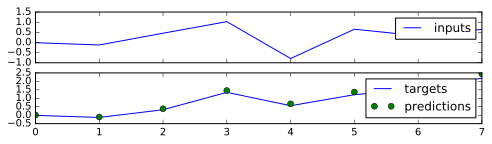

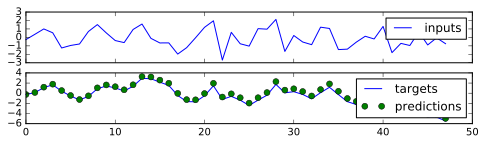

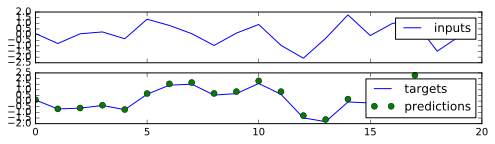

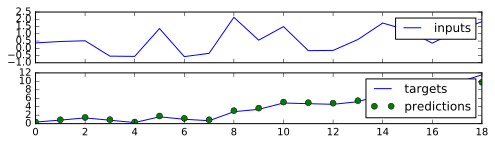

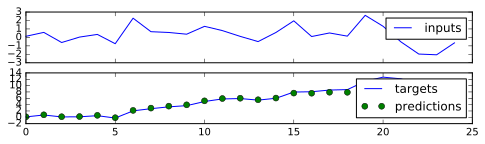

In [10]:
# 64 GRU
test_qualitatively(sess, model, generator, figsize=(8, 2))

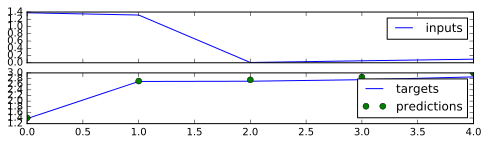

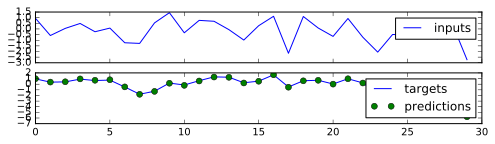

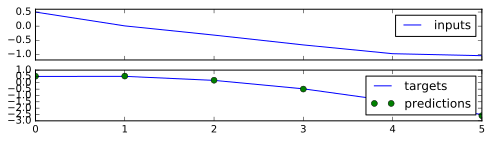

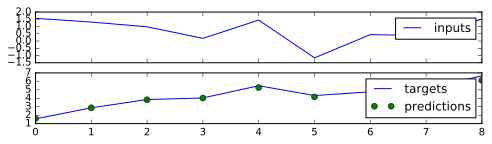

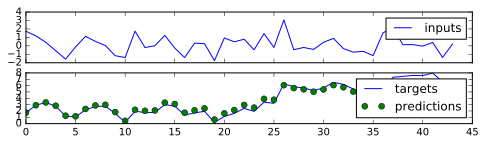

In [10]:
# 16 GRU
test_qualitatively(sess, model, generator, figsize=(8, 2))

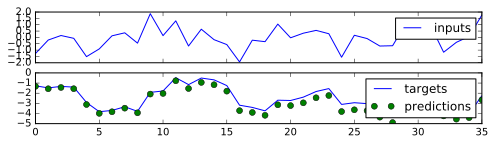

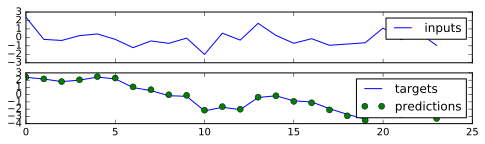

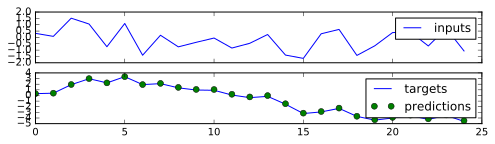

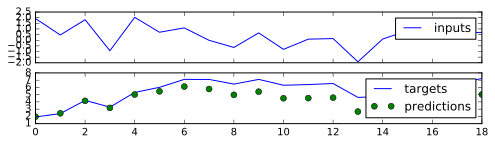

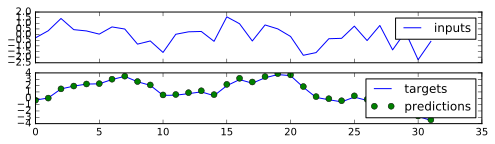

In [10]:
# 16
test_qualitatively(sess, model, generator, figsize=(8, 2))

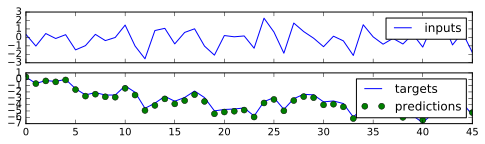

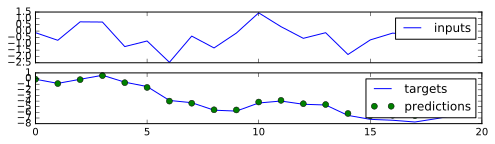

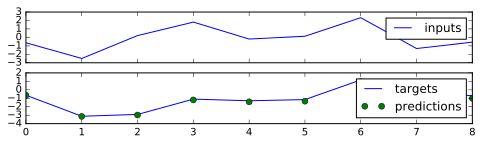

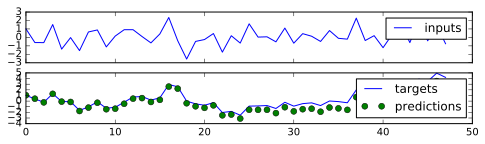

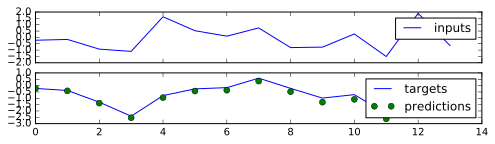

In [10]:
# 32
test_qualitatively(sess, model, generator, figsize=(8, 2))

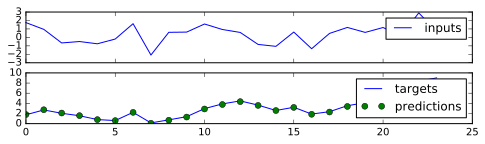

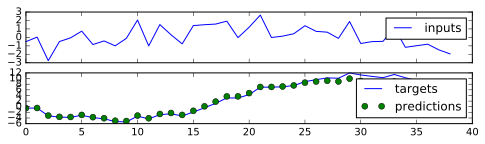

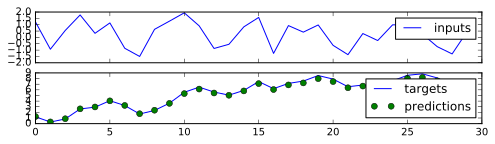

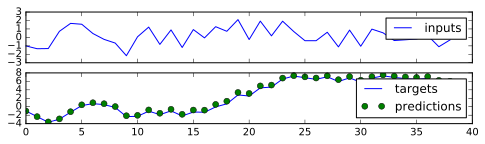

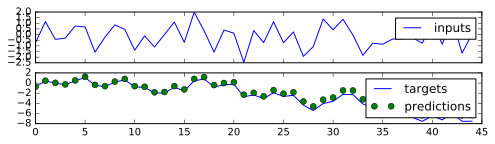

In [10]:
# 64
test_qualitatively(sess, model, generator, figsize=(8, 2))

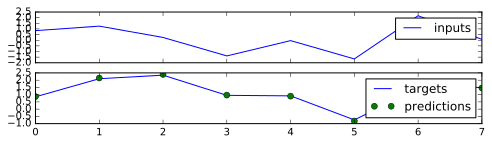

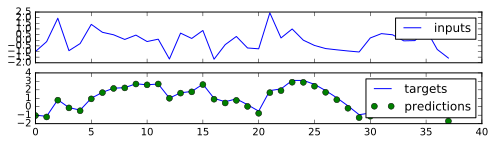

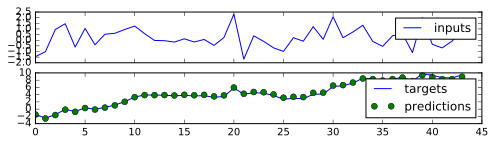

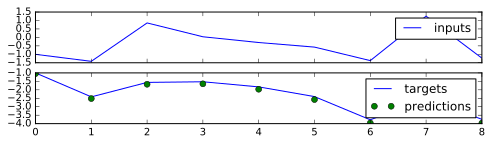

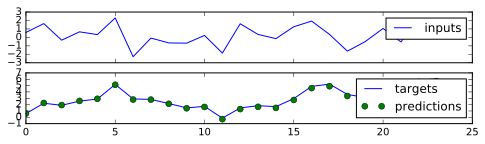

In [11]:
# 128
test_qualitatively(sess, model, generator, figsize=(8, 2))

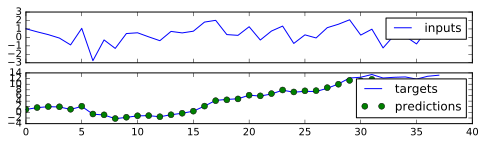

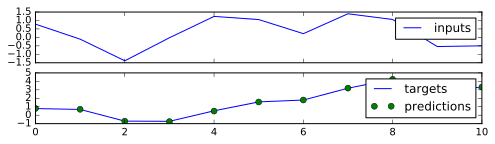

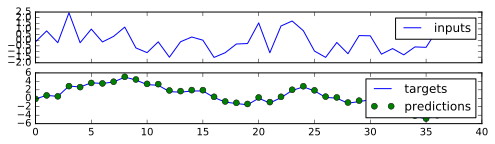

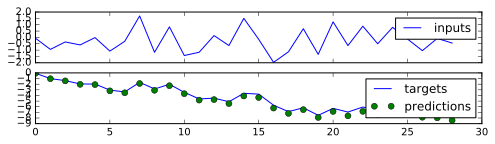

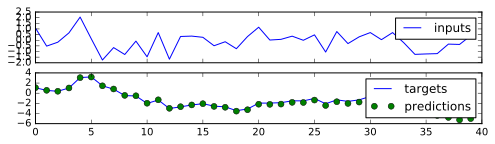

In [11]:
# 256
test_qualitatively(sess, model, generator, figsize=(8, 2))